## Applying_Deep_Learning_Techniques_to_Estimate_Patterns_of_Musical_Gesture

In the following code we are going to check what sort of data we have. The data was taken from the Myo sensor, which was placed in the expert violin performes right-hand forearm.

The following code provide all the Deep Learning techniques applied in the related paper using Tensorflow library.

We used:

- Python '3.6.8'
- TensorFlow '2.0.0'
- NumPy '1.17.4'
- Scikit-learn '0.23.1'
- Pyquaternion '0.9.5'.

### Abstract

Repetitive practice is one of the most important factors in improving the performance of motor skills. This paper focuses on the analysis and classification of forearm gestures in the context of violin playing. We recorded five experts and three students performing eight traditional classical violin bow-strokes: martelé, staccato, detaché, ricochet, legato, trémolo, collé, and col legno. To record inertial motion information, we utilized the Myo sensor, which reports a multidimensional time-series signal. We synchronized inertial motion recordings with audio data to extract the spatiotemporal dynamics of each gesture. Applying state-of-the-art deep neural networks, we implemented and compared different architectures where convolutional neural networks (CNN) models demonstrated recognition rates of 97.147%, 3DMultiHeaded_CNN models showed rates of 98.553%, and rates of 99.234% were demonstrated by CNN_LSTM models. The collected data (quaternion of the bowing arm of a violinist) contained sufficient information to distinguish the bowing techniques studied, and deep learning methods were capable of learning the movement patterns that distinguish these techniques. Each of the learning algorithms investigated (CNN, 3DMultiHeaded_CNN, and CNN_LSTM) produced high classification accuracies which supported the feasibility of training classifiers. The resulting classifiers may provide the foundation of a digital assistant to enhance musicians’ time spent practicing alone, providing real-time feedback on the accuracy and consistency of their musical gestures in performance.

### Materials

Eight bow-strokes were recorded by musicians following a musical score with a fixed metronome tempo of quarter-notes at 80 bpm. All gestures were established in G, primarily in the major mode except for tremolo (G minor) and col legno (chromatic). On the violin, two octaves from G3 to G5 covers the whole neck and also all four strings. Eight musicians participated in the recording sessions, with expert models constructed using the data from five violinists; the other three participants were reserved as test cases. The recordings are part of a collaboration with the Royal College of Music in London.

<img src="figures/01_music_score_eight_gestures.jpg" alt="Drawing" style="width: 700px;"/>

### Drawing the Gestures

<img src="figures/12_Gestures.jpg" alt="Drawing" style="width: 700px;"/>

### Cluster of Data
All the samples as a 3D representation after translating the Quaternion data into Euler angles:

<img src="figures/03_Cluster_Data.jpg" alt="Drawing" style="width: 700px;"/>

### Visualizing the data

In [21]:
# plot all vars for one subject in the har dataset
import numpy as np
import csv
from matplotlib import pyplot

In [22]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [23]:
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [24]:
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '/' + '10_label.csv').astype(np.int)
    return X, y

In [25]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

In [26]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

In [27]:
# plot the data for one subject
def plot_subject(X, y, gSize = 7):
    axis = ['x','y','z']
    axis_color = ['#33b8f0','#297ddc','#e1aa15', '#e23b1a']
    lw = 1
    pyplot.figure(figsize=(10, 8))
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]), c = axis_color[i], linewidth=lw)
        pyplot.title(' acc_'+axis[i], y=0, loc='left', pad = 20, size=gSize)
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot body acc
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]), c = axis_color[i], linewidth=lw)
        pyplot.title(' gyro_'+axis[i], y=0, loc='left', pad = 20, size=gSize)
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot body gyro
    for i in range(3):
        pyplot.subplot(n, 1, off+1)
        pyplot.plot(to_series(X[:, :, off]), c = axis_color[i], linewidth=lw)
        pyplot.title(' euler_'+axis[i], y=0, loc='left', pad = 20, size=gSize)
        # turn off ticks to remove clutter
        pyplot.yticks([])
        pyplot.xticks([])
        off += 1
    # plot activities
    pyplot.subplot(n, 1, n)
    pyplot.plot(y, c = axis_color[3], linewidth=lw)
    pyplot.title(' gesture', y=0, loc='left', pad = 20, size=gSize)
    # turn off ticks to remove clutter
    pyplot.yticks([])
    pyplot.xticks([])
    pyplot.tight_layout()
    pyplot.show()

Take into account that the data is already shuffled. That is visible in the gesture label 

['1' '2' '3' '4' '5']
(194, 150, 9) (194, 1)


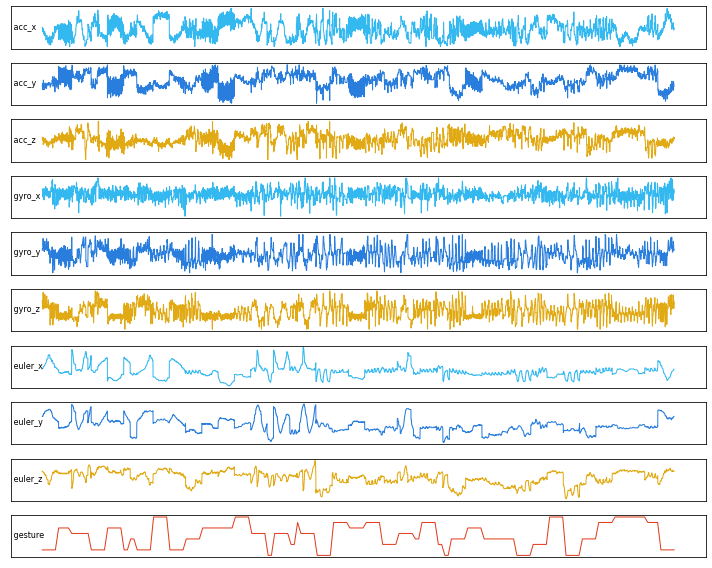

In [28]:
# load data
trainX, trainy = load_dataset('train', 'data/Gestures/Groups/')
# load mapping of rows to subjects
sub_map = load_file('data/Gestures/Groups/train/11_subject.csv')
train_subjects = np.unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[2]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby, 8)

The data characteristics comprised fixed windows of 0.375 s, given 150 data points to observe, with 50% overlap. This method is a standard data augmentation technique. The format was then stored in a folder containing nine matrices made of a single sensor axis. All files (acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, euler_x, euler_y, euler_z) were made of samples(n), time-steps(150). For instance, after dividing the data into training and test by 80–20 %, we have an input_shape for training data of [940,150,9].

In [30]:
# plot histograms for multiple subjects
def plot_subject_histograms(X, y, sub_map, offset, n=5):
    pyplot.figure()
    # get unique subjects
    subject_ids = np.unique(sub_map[:,0])
    #colors
    axis_color = ['#33b8f0', '#297ddc', '#e1aa15', '#e23b1a']
    # enumerate subjects
    for k in range(n):
        sub_id = subject_ids[k]
        # get data for one subject
        subX, _ = data_for_subject(X, y, sub_map, sub_id)
        # total acc
        for i in range(3):
            ax = pyplot.subplot(n, 1, k+1)
            ax.set_xlim(-1,1)
            ax.hist(to_series(subX[:,:,offset+i]), bins=100, color=axis_color[i])
            pyplot.yticks([])
            pyplot.xticks([-1,0,1])
            pyplot.tight_layout()
    pyplot.show()

/Users/david/miniconda2/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


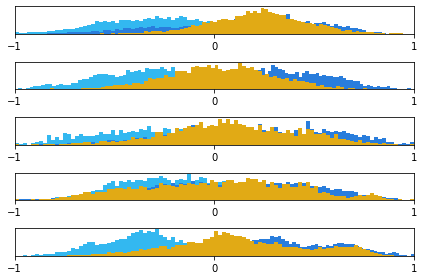

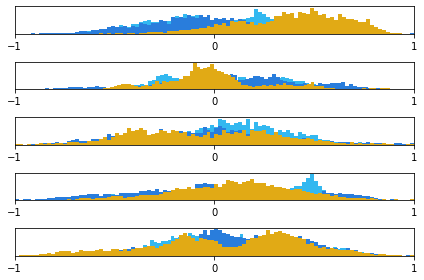

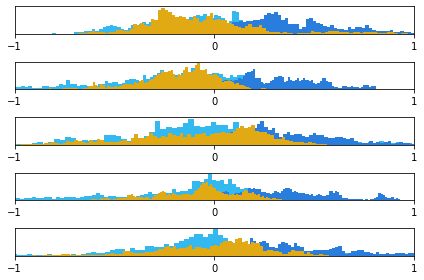

In [31]:
# load training dataset
X, y = load_dataset('train', 'data/Gestures/Groups/')
# load mapping of rows to subjects
sub_map = load_file('data/Gestures/Groups/train/11_subject.csv')
# plot total acceleration histograms for subjects
plot_subject_histograms(X, y, sub_map, 0)
# plot body acceleration histograms for subjects
plot_subject_histograms(X, y, sub_map, 3)
# plot gyroscopic histograms for subjects
plot_subject_histograms(X, y, sub_map, 6)

## Machine Learning Models
Let's start evaluating some standard Machine Learning models from sklearn library

In [32]:
# check the raw data from the myo dataset
from numpy import dstack
from numpy import vstack
from pandas import read_csv
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [33]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delimiter=',')
    return dataframe.values

In [34]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [35]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv']
    # body acceleration
    filenames += ['04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv']
    # body gyroscope
    filenames += ['07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '10_label.csv')
    return X, y

In [36]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    print(testX.shape, testy.shape)
    # flatten X
    trainX = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
    testX = testX.reshape((testX.shape[0], testX.shape[1] * testX.shape[2]))
    # flatten y
    trainy, testy = trainy[:,0], testy[:,0]
    print("Dataset loaded correclty")
    return trainX, trainy, testX, testy

In [37]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    n_estimators = 100
    # nonlinear models
    models['KNeighbors'] = KNeighborsClassifier(n_neighbors=3)
    models['Decision Tree'] = DecisionTreeClassifier(random_state=1, criterion='entropy', splitter='random')
    models['SVM'] = SVC(gamma='auto', kernel="linear", C=0.15, class_weight='balanced')
    models['Naive Bayes'] = GaussianNB()
    models['Gaussian Process'] = GaussianProcessClassifier(1.0 * RBF(1.33))
    # ensemble models
    models['Bagging'] = BaggingClassifier(n_estimators=n_estimators)
    models['Random Forest'] = RandomForestClassifier(n_estimators=n_estimators)
    models['Extra Trees'] = ExtraTreesClassifier(n_estimators=n_estimators)
    models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=n_estimators)
    print('Defined %d models' % len(models))
    return models

In [38]:
# evaluate a single model
def evaluate_model(trainX, trainy, testX, testy, model):
    # fit the model
    model.fit(trainX, trainy)
    # make predictions
    yhat = model.predict(testX)
    # evaluate predictions
    accuracy = accuracy_score(testy, yhat)
    return accuracy * 100.0

In [39]:
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        results[name] = evaluate_model(trainX, trainy, testX, testy, model)
        # show process
        print('>%s: %.3f' % (name, results[name]))
    return results

In [40]:
# print and plot the results
def summarize_results(results, maximize=True):
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,v) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    print()
    for name, score in mean_scores:
        print('%s, classifier &%.3f' % (name, score))

In [41]:
# load dataset
trainX, trainy, testX, testy = load_dataset()

(940, 150, 9) (940, 1)
(235, 150, 9) (235, 1)
Dataset loaded correclty


In [42]:
# get model list
models = define_models()

Defined 9 models


In [43]:
# evaluate models
results = evaluate_models(trainX, trainy, testX, testy, models)

>KNeighbors: 90.638
>Decision Tree: 71.915
>SVM: 86.809
>Naive Bayes: 61.277
>Gaussian Process: 97.447
>Bagging: 92.340
>Random Forest: 94.894
>Extra Trees: 95.745
>Gradient Boosting: 91.064


In [1]:
# summarize results
summarize_results(results)

NameError: name 'summarize_results' is not defined

## 3D Data Format
The shape of the 3D data to be passed to the LSTM models is given by (Samples, Time-steps, Features). As you might see in the data/Gestures/All folder, features are organised in independent files from 1 to 9 wich each of them are the axes per sensor device (Accelerometer, Gyroscope and Magnetometer).
<img src="figures/04_3D_Data.jpg" alt="Drawing" style="width: 600px;"/>

## Chapter 1: First CNN model

In [45]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import csv
import tensorflow as tf

In [46]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [47]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [48]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array

    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [49]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [3]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, 9, activation='relu', input_shape=(n_timesteps,n_features)),
        tf.keras.layers.Conv1D(64, 9, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(n_outputs, activation='softmax')
    ])
    tf.keras.utils.plot_model(model, show_shapes=False, to_file='figures/CNN.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [5]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

### Run the experiment

In [54]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    print(trainX.shape, trainy.shape)
    #print(trainy)
    # repeat experiment
    scores = list()

    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [55]:
# run the experiment
run_experiment()

(940, 150, 9) (940, 8)
>#1: 99.574
>#2: 96.596
>#3: 94.894
>#4: 99.574
>#5: 99.149
>#6: 99.149
>#7: 98.298
>#8: 99.149
>#9: 98.723
>#10: 97.447
[99.57447052001953, 96.59574627876282, 94.89361643791199, 99.57447052001953, 99.14893507957458, 99.14893507957458, 98.29787015914917, 99.14893507957458, 98.72340559959412, 97.44681119918823]
Accuracy: 98.255% (+/-1.442)


## Chapter 2: CNN Tune Filter
Now we are going to need some Standardization:

In [65]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from matplotlib import pyplot
import csv
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [66]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [67]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [68]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [69]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [70]:
def scale_data(trainX, testX, standardize=True):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # flatten train and test
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # standardize
    if standardize:
        s = StandardScaler()
        # fit on training data
        s.fit(longX)
        # apply to training and test data
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

In [71]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    trainX, testX = scale_data(trainX, testX)

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(n_filters, 3, activation='relu', input_shape=(n_timesteps, n_features)),
        tf.keras.layers.Conv1D(n_filters, 3, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [72]:
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')
    pyplot.show()

In [73]:
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

In [74]:
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

>p=8 #1: 85.106
>p=8 #2: 85.957
>p=8 #3: 87.234
>p=8 #4: 83.830
>p=8 #5: 93.617
>p=8 #6: 85.957


KeyboardInterrupt: 

## Chapter 3: Multi-headed CNN model

In [75]:
import numpy as np
import csv
import tensorflow as tf

In [76]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [77]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [78]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [79]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [80]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = tf.keras.layers.Input(shape=(n_timesteps,n_features))
    conv1 = tf.keras.layers.Conv1D(64, 3, activation='relu')(inputs1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D()(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # head 2
    inputs2 = tf.keras.layers.Input(shape=(n_timesteps,n_features))
    conv2 = tf.keras.layers.Conv1D(64, 5, activation='relu')(inputs2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D()(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # head 3
    inputs3 = tf.keras.layers.Input(shape=(n_timesteps,n_features))
    conv3 = tf.keras.layers.Conv1D(64, 9, activation='relu')(inputs3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D()(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(100, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(n_outputs, activation='softmax')(dense1)
    model = tf.keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=True, to_file='figures/multiheaded.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy

In [81]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [82]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [83]:
# run the experiment
run_experiment()

>#1: 98.723
>#2: 98.298
>#3: 99.149
>#4: 97.872
>#5: 98.723
>#6: 97.447


KeyboardInterrupt: 

## Chapter 4: LSTM model

In [84]:
import numpy as np
import csv
import tensorflow as tf

In [85]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [86]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [87]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [88]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [89]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 25, 8
    print(trainX.shape, testX.shape)
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(n_outputs, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [90]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [91]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [92]:
# run the experiment
run_experiment()

(940, 150, 9) (235, 150, 9)
Train on 940 samples
Epoch 1/25
940/940 [==============================] - 9s 10ms/sample - loss: 1.7789 - accuracy: 0.3245
Epoch 2/25
940/940 [==============================] - 7s 8ms/sample - loss: 1.3417 - accuracy: 0.5021
Epoch 3/25
940/940 [==============================] - 7s 8ms/sample - loss: 1.1181 - accuracy: 0.5766
Epoch 4/25
940/940 [==============================] - 7s 8ms/sample - loss: 0.9029 - accuracy: 0.6766
Epoch 5/25
940/940 [==============================] - 9s 9ms/sample - loss: 0.7479 - accuracy: 0.7245
Epoch 6/25
940/940 [==============================] - 7s 8ms/sample - loss: 0.6505 - accuracy: 0.7755
Epoch 7/25
940/940 [==============================] - 7s 8ms/sample - loss: 0.5481 - accuracy: 0.8138
Epoch 8/25
940/940 [==============================] - 8s 8ms/sample - loss: 0.5272 - accuracy: 0.8191
Epoch 9/25
940/940 [==============================] - 7s 8ms/sample - loss: 0.4728 - accuracy: 0.8372
Epoch 10/25
940/940 [===========

KeyboardInterrupt: 

## Chapter 5: Hybrid CNN_LSTM Model

In [ ]:
import numpy as np
import csv
import tensorflow as tf
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [ ]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']
    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [93]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [94]:
def non_nan_average(x):
    # Computes the average of all elements that are not NaN in a rank 1 tensor
    nan_mask = tf.math.is_nan(x)
    x = tf.boolean_mask(x, tf.logical_not(nan_mask))
    return tf.keras.backend.mean(x)

In [95]:
def uar_accuracy(y_true, y_pred):
    c_mat = confusion_matrix(y_true, y_pred)
    #print(c_mat)

    # These operations needed for image summary
    cf_mat1 = tf.cast(c_mat, tf.dtypes.float32)
    cf_mat1 = tf.expand_dims(cf_mat1, 2)
    cf_mat1 = tf.expand_dims(cf_mat1, 0)

    diag = tf.linalg.tensor_diag_part(c_mat)
    # Calculate the total number of data examples for each class
    total_per_class = tf.reduce_sum(c_mat, axis=1)
    acc_per_class = diag / tf.maximum(1, total_per_class)
    uar = non_nan_average(acc_per_class)
    return uar

In [104]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, lSize):
    # define model
    batch_size = 32
    verbose, epochs = 1, 20 #best batch so far is 32
    n_features, n_outputs = trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 3, 50 #best so far is 5 30
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(lSize, 3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(lSize, 3, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5)))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D()))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(tf.keras.layers.LSTM(100))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=True, to_file='figures/CNN_LSTM.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

    Y_test = np.argmax(testy, axis=1)  # Convert one-hot to index
    y_pred = model.predict_classes(testX)
    print(classification_report(Y_test, y_pred))
    matrix = uar_accuracy(Y_test, y_pred)
    #print(matrix)
    return accuracy

In [105]:
# summarize scores
def summarize_results(scores, params, saveit = False):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param = %d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    if saveit:
        pyplot.savefig('batches_CNN_LSTM_2.png')
    pyplot.show()

In [106]:
# run an experiment
def run_experiment(repeats=1):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    final_scores = list()
    #sizes = [32, 64, 128, 256, 512]
    factor = 94
    ref = [10,20,30,40,50,60,70,80,90,100]
    #score = evaluate_model(trainX, trainy, testX, testy, 512)

    for i in range(len(ref)):
        scores = list()
        for r in range(repeats):
            ms = (i+1)*factor
            trainX_ = trainX[:ms, :, :]
            trainy_ = trainy[:ms, :]
            print(trainX_.shape, trainy_.shape)
            score = evaluate_model(trainX_, trainy_, testX, testy, 2256)
            score = score * 100.0
            print('#%d: %.3f' % (i+1, score))
            scores.append(score)
            tf.keras.backend.clear_session()
        final_scores.append(scores)
    # summarize results
    summarize_results(final_scores, ref)
    print(final_scores)

The experiment argument will determine how meny times the model will be tested. 

In [107]:
# run the experiment
run_experiment(1)

(94, 150, 9) (94, 8)
Train on 94 samples
Epoch 1/20
94/94 [==============================] - 19s 201ms/sample - loss: 2.2139 - accuracy: 0.2500


KeyboardInterrupt: 

## Chapter 6: ConvLSTM Model

In [ ]:
import numpy as np
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(row)
    return np.array(data)

In [108]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group
    # load all 9 files as a single array

    # total acceleration
    filenames = ['01_acc_x.csv', '02_acc_y.csv', '03_acc_z.csv',
                 '04_gyro_x.csv', '05_gyro_y.csv', '06_gyro_z.csv',
                 '07_euler_x.csv', '08_euler_y.csv', '09_euler_z.csv']

    # load input data
    X = load_group(filenames, filepath).astype(np.float64)
    # load class output
    y = load_file(prefix + group + '10_label.csv').astype(np.int)
    return X, y

In [109]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train/', prefix + 'data/Gestures/Groups/')
    # load all test
    testX, testy = load_dataset_group('test/', prefix + 'data/Gestures/Groups/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = tf.keras.utils.to_categorical(trainy)
    testy = tf.keras.utils.to_categorical(testy)
    return trainX, trainy, testX, testy

In [115]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, batches):
    # define model
    batch_size = batches
    verbose, epochs = 1, 50
    n_features, n_outputs = trainX.shape[2], trainy.shape[1]
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    n_steps, n_length = 3, 50
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    # define model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.ConvLSTM2D(64, (1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    tf.keras.utils.plot_model(model, show_shapes=False, show_layer_names=True, to_file='figures/Conv_LSTM_Model.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy))
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy, history

In [116]:
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param = %d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    plt.boxplot(scores, labels=params)
    plt.savefig('ConvLSTM2D.png')
    plt.show()

In [117]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    final_scores = list()
    batches = [8, 16, 32, 64, 128, 256]
    for i in range(len(batches)):
        scores = list()
        # repeat experiment
        for r in range(repeats):
            score, history = evaluate_model(trainX, trainy, testX, testy, batches[i])
            score = score * 100.0
            print('>#%d: %.3f' % (r+1, score))
            scores.append(score)
        # summarize results
        final_scores.append(scores)
    summarize_results(final_scores, batches)
    return score, history

In [123]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 50, 0, 0.5])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [124]:
_, history = run_experiment(1)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

Train on 940 samples, validate on 235 samples
Epoch 1/50
940/940 [==============================] - 7s 7ms/sample - loss: 1.4920 - accuracy: 0.4564 - val_loss: 1.0296 - val_accuracy: 0.6511
Epoch 2/50
940/940 [==============================] - 4s 4ms/sample - loss: 0.5886 - accuracy: 0.7979 - val_loss: 0.5988 - val_accuracy: 0.7489
Epoch 3/50
940/940 [==============================] - 3s 3ms/sample - loss: 0.2583 - accuracy: 0.9234 - val_loss: 0.3172 - val_accuracy: 0.9064
Epoch 4/50
940/940 [==============================] - 3s 3ms/sample - loss: 0.1711 - accuracy: 0.9489 - val_loss: 0.4662 - val_accuracy: 0.8340
Epoch 5/50
940/940 [==============================] - 3s 3ms/sample - loss: 0.0825 - accuracy: 0.9755 - val_loss: 0.2365 - val_accuracy: 0.9234
Epoch 6/50
940/940 [==============================] - 4s 4ms/sample - loss: 0.0622 - accuracy: 0.9798 - val_loss: 0.2784 - val_accuracy: 0.9191
Epoch 7/50
940/940 [==============================] - 4s 4ms/sample - loss: 0.0263 - accur

KeyboardInterrupt: 

## The paper is available here:
[Applying Deep Learning Techniques to Estimate Patterns of Musical Gesture](https://www.frontiersin.org/articles/10.3389/fpsyg.2020.575971/full)